In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime

In [ ]:
df_ratings = pd.read_csv('../raw/ml-20m/ratings.csv')
df_ratings

Dividimos el conjunto de datos en Test y Train

In [5]:
# 2M de datos para evaluar el modelo final y 18M para entrenar y validar
train, test = train_test_split(df_ratings, test_size=0.1, random_state=43)

In [10]:
# Guardar csv con datos separados
train.to_csv('../raw/ml-20m/train_ratings.csv')
test.to_csv('../raw/ml-20m/test_ratings.csv')

Analizamos set de datos de entrenamiento

In [2]:
df_train= pd.read_csv('../raw/ml-20m/train_ratings.csv')
df_train.drop('Unnamed: 0', axis =1, inplace=True)

In [3]:
df_train

,userId,movieId,rating,timestamp
0,4276,6537,2.0,1166745600
1,106451,1252,5.0,938856724
2,110359,4896,4.0,1026736453
3,55651,5292,4.0,1339373664
4,107640,813,2.0,1082740213
...,...,...,...,...
18000231,131630,1672,4.0,1081218783
18000232,7547,3039,3.5,1121665512
18000233,9738,7445,3.0,1095175492
18000234,16826,4239,5.0,1039451088


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000236 entries, 0 to 18000235
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 549.3 MB


Tenemos un total de 18.000.000 de registros y 4 columnas (siendo una de ellas el id)

In [7]:
df_train.isna().sum() # Comprobamos valores nulos

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Informacion general

In [13]:
# Contamos cuantos usuarios tenemos en total.
total_user=df_train['userId'].nunique()
print('Total de usuarios:',total_user)

Total de usuarios: 138493


In [14]:
# Contamos cuantas peliculas tenemos en total.
total_movies=df_train['movieId'].nunique()
print('Total de peliculas:',total_movies)

Total de peliculas: 26349


In [20]:
# Maxima y Minima puntuacion dada en el conjunto de datos
max_rating = df_train['rating'].max()
min_rating = df_train['rating'].min()
print('Maxima puntuacion:',max_rating)
print('Minima puntuacion:',min_rating)

Maxima puntuacion: 5.0
Minima puntuacion: 0.5


In [21]:
# Estadisticos Descriptivos
df_train.describe()

,userId,movieId,rating,timestamp
count,1.800024e+07,1.800024e+07,1.800024e+07,1.800024e+07
mean,6.904791e+04,9.041715e+03,3.525431e+00,1.100912e+09
std,4.003851e+04,1.979007e+04,1.051973e+00,1.621689e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,3.439500e+04,9.020000e+02,3.000000e+00,9.667957e+08
50%,6.914100e+04,2.167000e+03,3.500000e+00,1.103509e+09
75%,1.036400e+05,4.769000e+03,4.000000e+00,1.225635e+09
max,1.384930e+05,1.312620e+05,5.000000e+00,1.427784e+09


Analizamos el rating:

- Observamos que la media de puntuaciones se situa en 3,5 puntos.
- La desviacion con respecto a la media es de 1 punto (arriba o abajo).
- El 50% del conjunto de nuestra distribucion se situa entre 3-4 puntos (valores con mayor frecuencia).

Estos descriptivos nos hacen pensar en como el promedio de los usuarios puntuan neutralmente las peliculas.
La diversidad de opiniones ronda los 2,5 o 4,5 puntos, negativo o positivo. Siendo estos valores ultimos menos frecuentes.

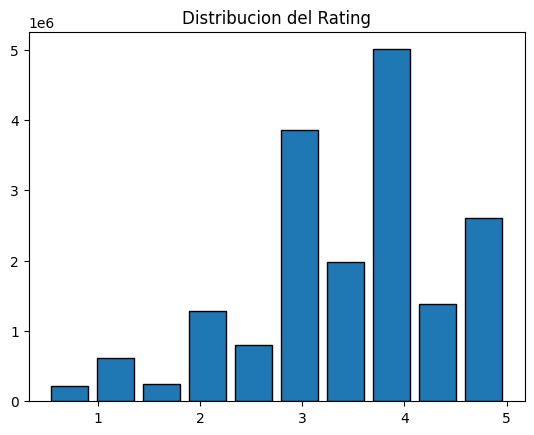

In [7]:
# Distribucion grafica Rating
plt.hist(x=df_train['rating'],rwidth=0.8, edgecolor='black')
plt.title('Distribucion del Rating')
plt.show()

- La mayor de frecuencia se da en la puntuacion 4, por tanto, estamos ante un conjunto de datos cuyas peliculas se han valorado positivamente.
- Como dijimos en el analisis descriptivo, los extremos se presentan como la menor frecuencia en las puntuaciones. Esto puede ser debido a que los usuarios prefieren ser mas moderados.

Posteriormente la metrica que utilizare para medir el rating sera la mediana, dado los valores altos.

Analisis de Correlacion entre variables

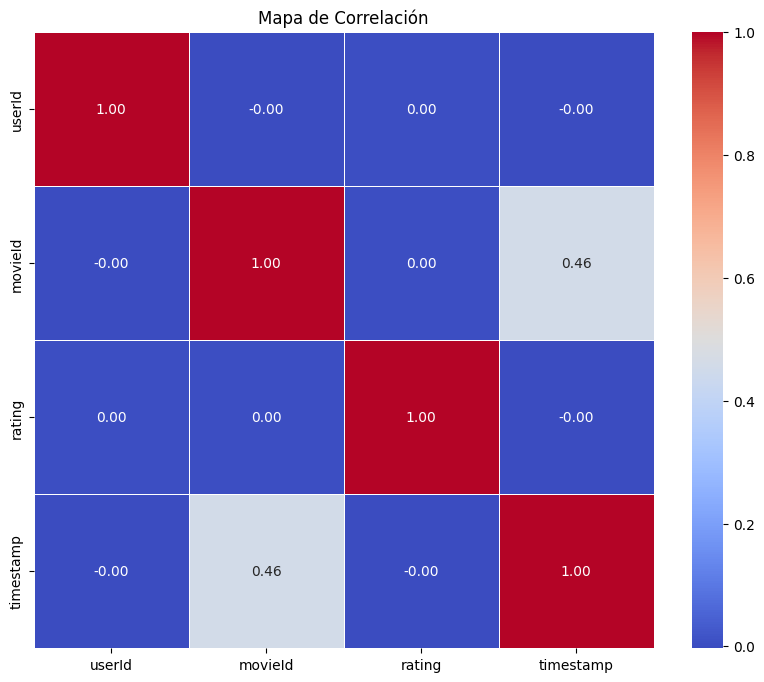

In [3]:
# Correlacion
correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Correlación')
plt.show()

Solo observamos una relacion positiva baja entre movieId y timestamp

- Esta relacion positiva puede darse debido a factores especificos: tendencias de moda, temporadas o probabilistica.

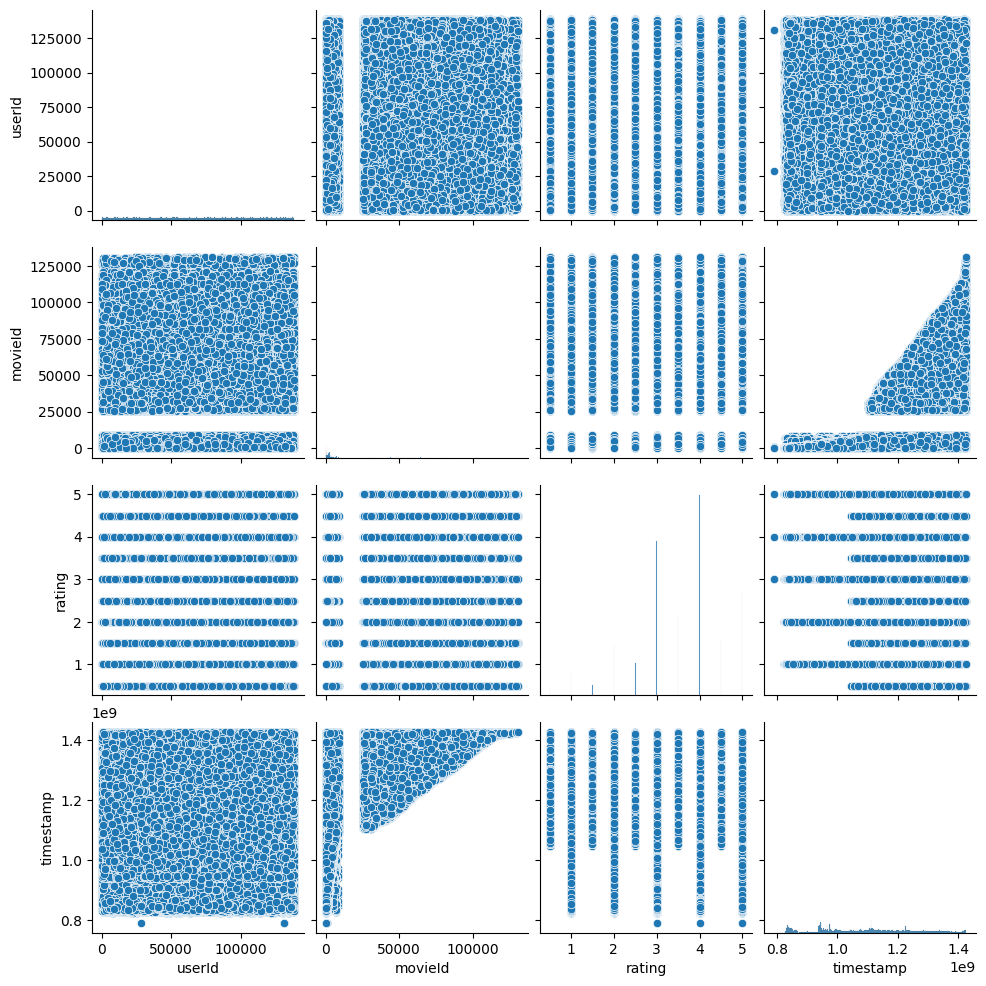

In [5]:
# Grafico de dispersion
scatter_matrix = sns.pairplot(df_train)
plt.show()

Lo primero que observamos es como la mayoria de relaciones son neutras, seguido esto de un gap (hueco).
Este gap se debe a la falta de datos tras separar el conjunto original en train y test.

- Las variables correlacionadas con un coeficiente de 0.46, presentan una situacion bastante curiosa: Al tener mas peliculas de un determinado periodo (ultimos 20 años), también se generan mas puntuaciones (rating) de esas mismas en un determinado tiempo (timestamp).
 
- Finalmente las causas son tanto probabilisticas como tendenciales: Si tengo mas peliculas del año 2000 en adelante, las puntuaciones seran la mayoria de ese periodo. 


*Nota: Revisar archivo (eda_movies.ipynb), aqui muestro en el apartado 'Analizar las fechas de lanzamiento' las distribuciones univariable y por genero, con eso se entedera mejor mi deduccion.*

In [3]:
df_train_copy = df_train.copy() # Creamos una copia para no modificar el df origen

In [4]:
# Convertimos el timestamp a datetime, luego aplicamos el formato año/mes/dia devolviendo un string
df_train_copy['date_rating'] = df_train_copy['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))

In [5]:
# Transformamos a Date el String
df_train_copy['date_rating'] = df_train_copy['date_rating'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [6]:
df_train_copy.drop('timestamp', axis=1, inplace=True) # Elimino variable timestamp (no la necesitare mas para los analisis)

Analisis de Fechas 

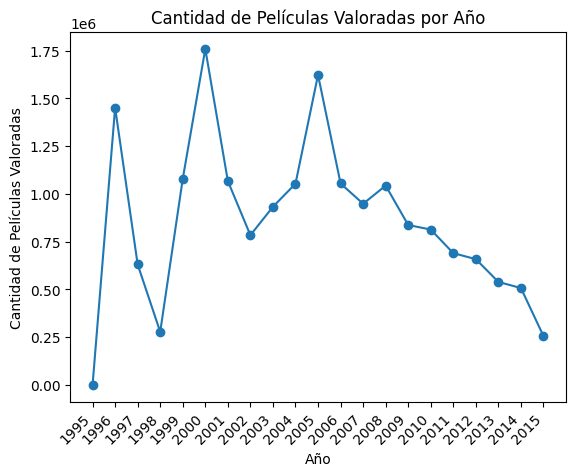

In [21]:
# Años y peliculas valoradas 

# Convertir las fechas a períodos anuales y contar la cantidad de películas por año
annio = df_train_copy['date_rating'].dt.to_period('Y').value_counts().sort_index()

# Grafico
plt.plot(annio.index.astype(str), annio.values, marker='o', linestyle='-')
plt.xlabel('Año')
plt.ylabel('Cantidad de Películas Valoradas')
plt.title('Cantidad de Películas Valoradas por Año')
plt.xticks(rotation=45, ha='right')
plt.show()

Podemos ver que las valoraciones comprenden un rango entre el 1995-2015.

Presenciamos picos de valoraciones en el año 1996, 2000 y 2006. 

Tambien caidas fuertes en los años 1998, 2002 y 2008 en adelante.

- Esto se debe a que los usuarios han valorado peliculas segun las tendencias y modas dadas en esa epoca. No olvidemos la frecuencia de los datos.
- Los ultimos años se nota una caida en las valoraciones.

Similar a lo expuesto anteriormente en el analisis de correlacion (ahora si, se confirma que disponemos de los ultimos 20 años de peliculas).

In [71]:
# Calcular las calificaciones mediana por mes
median_rating_by_month = df_train_copy.groupby(df_train_copy['date_rating'].dt.to_period("M"))['rating'].median()

# Calcular las calificaciones mediana por año
median_rating_by_year = df_train_copy.groupby(df_train_copy['date_rating'].dt.to_period("Y"))['rating'].median()

C:\Users\jarod\AppData\Local\Temp\ipykernel_3516\2600750935.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(median_rating_by_month.index.astype(str), rotation=65, ha='right')
C:\Users\jarod\AppData\Local\Temp\ipykernel_3516\2600750935.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(median_rating_by_year.index.astype(str), rotation=45, ha='right')


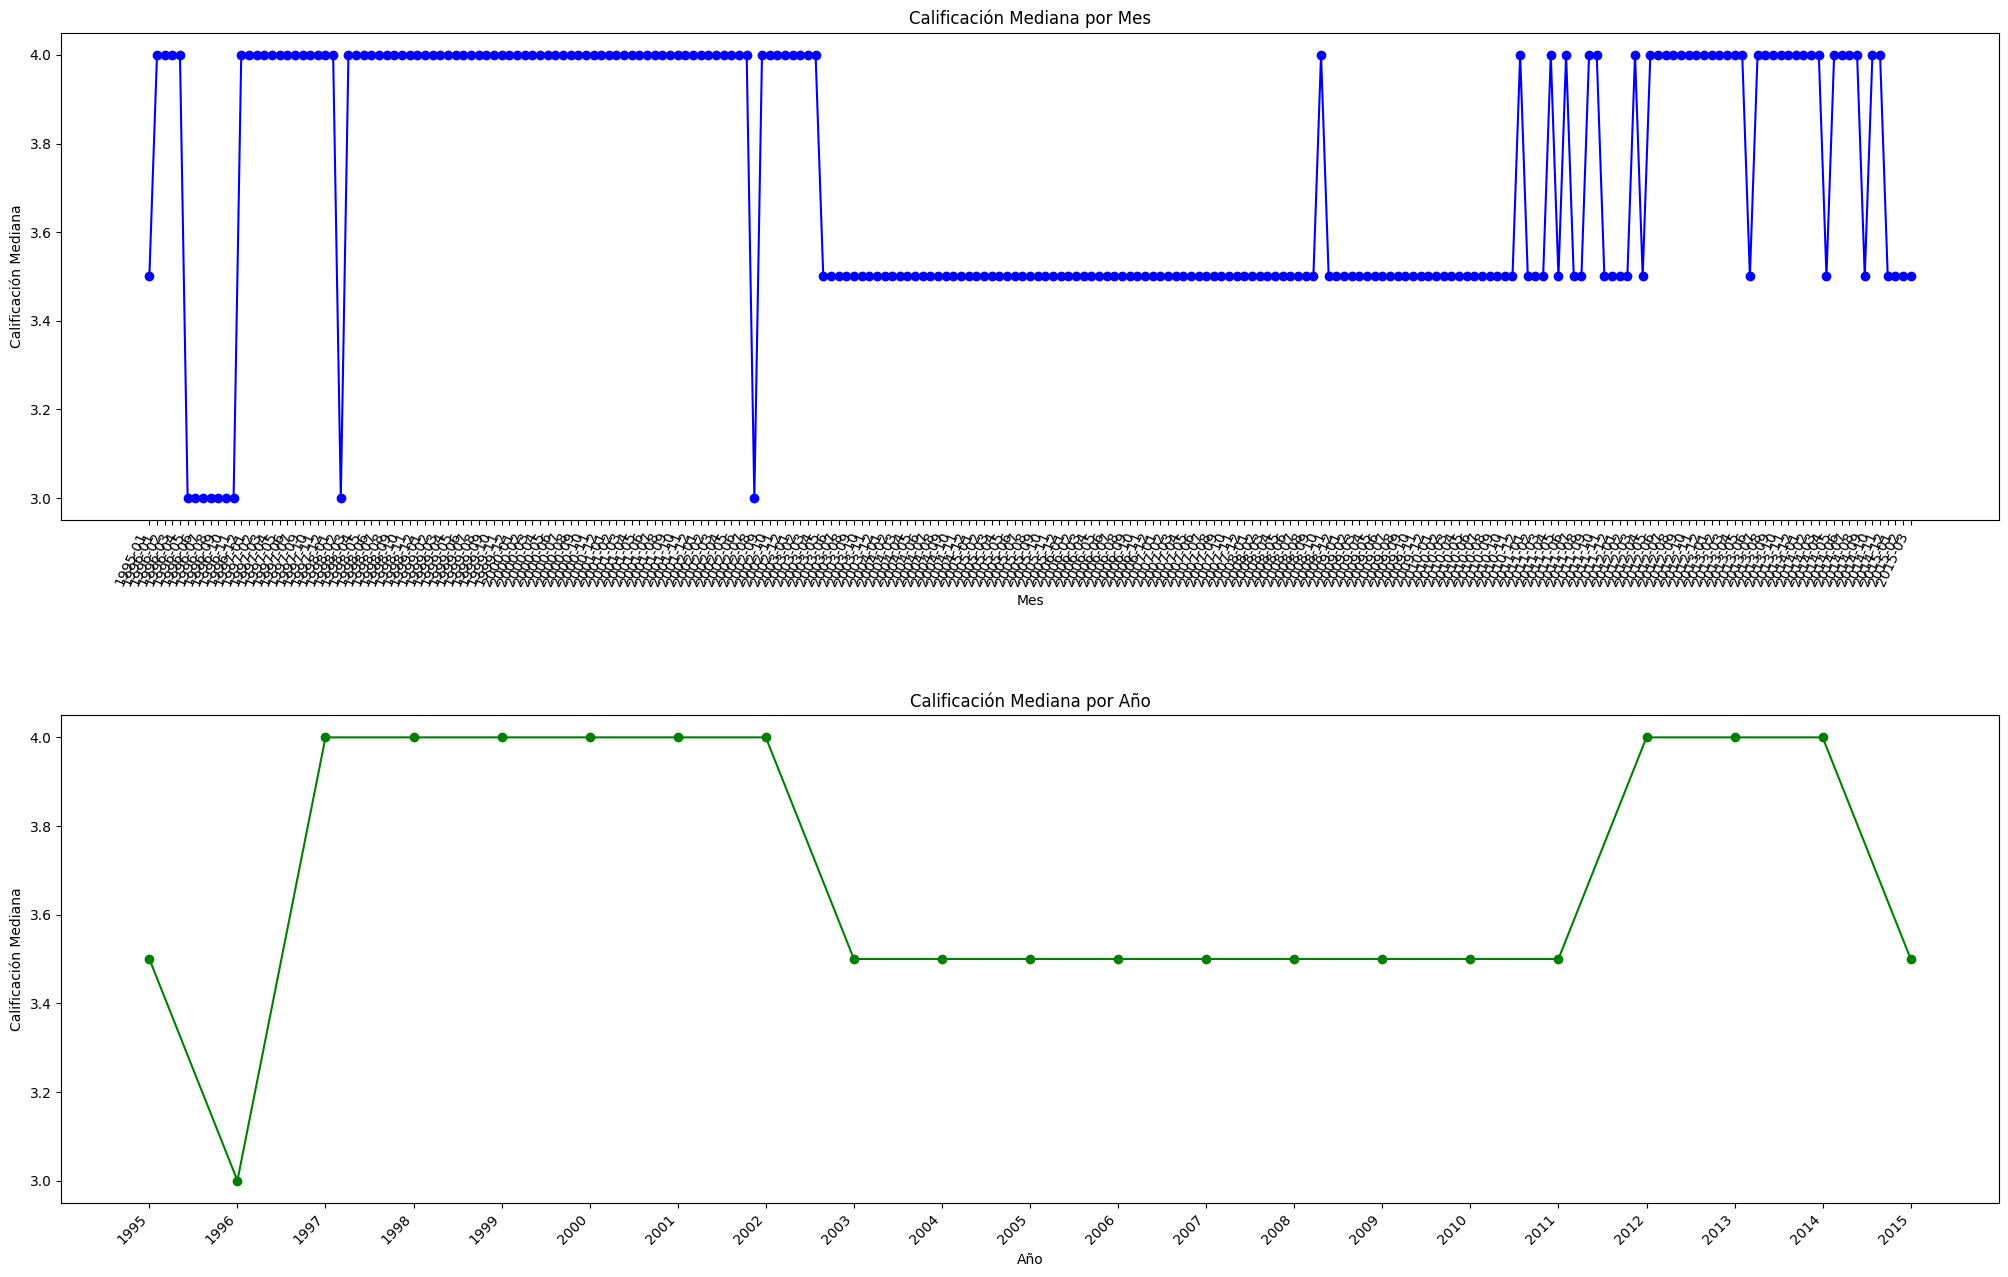

In [73]:
# Graficamos los resultados de la mediana
fig, axes = plt.subplots(2, 1, figsize=(25, 15), gridspec_kw={'hspace': 0.4})

# Graficar calificaciones mediana por mes
axes[0].plot(median_rating_by_month.index.astype(str), median_rating_by_month.values, marker='o', linestyle='-', color='blue')
axes[0].set_xlabel('Mes')
axes[0].set_ylabel('Calificación Mediana')
axes[0].set_title('Calificación Mediana por Mes')
axes[0].set_xticklabels(median_rating_by_month.index.astype(str), rotation=65, ha='right')

# Graficar calificaciones mediana por año
axes[1].plot(median_rating_by_year.index.astype(str), median_rating_by_year.values, marker='o', linestyle='-', color='green')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Calificación Mediana')
axes[1].set_title('Calificación Mediana por Año')
axes[1].set_xticklabels(median_rating_by_year.index.astype(str), rotation=45, ha='right')

# Ajustar el espacio en la parte inferior del primer subgráfico
fig.subplots_adjust(bottom=0.1)  

plt.show()

La mediana de las dos graficas se situa en valores positivos (entre 3-4 puntos de valoracion).

- Mensualmente la mediana alcanzó su cota mas alta de valoracion (4),bajando hasta 3.5 puntos.
- Anualmente podemos identificar valoraciones altas en los años 1997-2002 (4 puntos), cae en los años 2003-2011 (3.5 puntos), y vuelve a subir a 4 puntos los años posteriores.

Resumiendo, encontramos meses y años en los cuales la valoracion ha descendido o ascendido 0.5 puntos, por tanto estas fluctuacion se dan por temporadas.